In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -U -q tensorflow==2.17 tensorflow_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 43.6 MB/s eta 0:00:0000:0100:01


In [3]:
import os
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [4]:
seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
os.getcwd()

'/kaggle/working'

In [26]:
Dataset_path='/data/mini_speech_commands_extracted/mini_speech_commands'
data_dir=pathlib.Path(Dataset_path)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
        extract=True,
        cache_dir='.',cache_subdir='data')
print(data_dir)   

/data/mini_speech_commands_extracted/mini_speech_commands


In [27]:
commands=np.array(tf.io.gfile.listdir(str(data_dir)))
commands=commands[(commands != 'README.md') & (commands !='.DS_Store')]
print('Commands:',commands)

NotFoundError: Could not find directory /data/mini_speech_commands_extracted/mini_speech_commands

In [21]:
train_ds,val_ds=tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'

)
label_names=np.array(train_ds.class_names)
print()
print("label names:",label_names)

NotFoundError: Could not find directory /kaggle/working/data/mini_speech_commands_extracted/mini_speech_commands

In [22]:
train_ds.element_spec

NameError: name 'train_ds' is not defined

In [23]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

NameError: name 'train_ds' is not defined

In [13]:
test_ds=val_ds.shard(num_shards=2,index=0)
val_ds=val_ds.shard(num_shards=2,index=1)

NameError: name 'val_ds' is not defined

In [ ]:
for example_audio,example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

In [ ]:
label_names[[1,1,3,0]]

In [ ]:
plt.figure(figsize=(20,16))
rows=3
cols=3
n=rows*cols
for i in range(n):
    plt.subplot(rows,cols,i+1)
    audio_signal=example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2,1.2,0.2))
    plt.ylim([-1.1,1.1])

In [ ]:
def get_spectrogram(waveform):
    spectrogram=tf.signal.stft(waveform,frame_length=255,frame_step=128)
    spectrogram=tf.abs(spectrogram)
    spectrogram=spectrogram[...,tf.newaxis]
    return spectrogram

In [14]:
for i in range(3):
    label=label_names[example_labels[i]]
    waveform=example_audio[i]
    spectrogram=get_spectrogram(waveform)

    print("label",label)
    print("Waveform shape",waveform.shape)
    print("Spectrogram shape:",spectrogram.shape)
    print("audio playback")
    display.display(display.Audio(waveform,rate=16000))

NameError: name 'label_names' is not defined

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

NameError: name 'waveform' is not defined

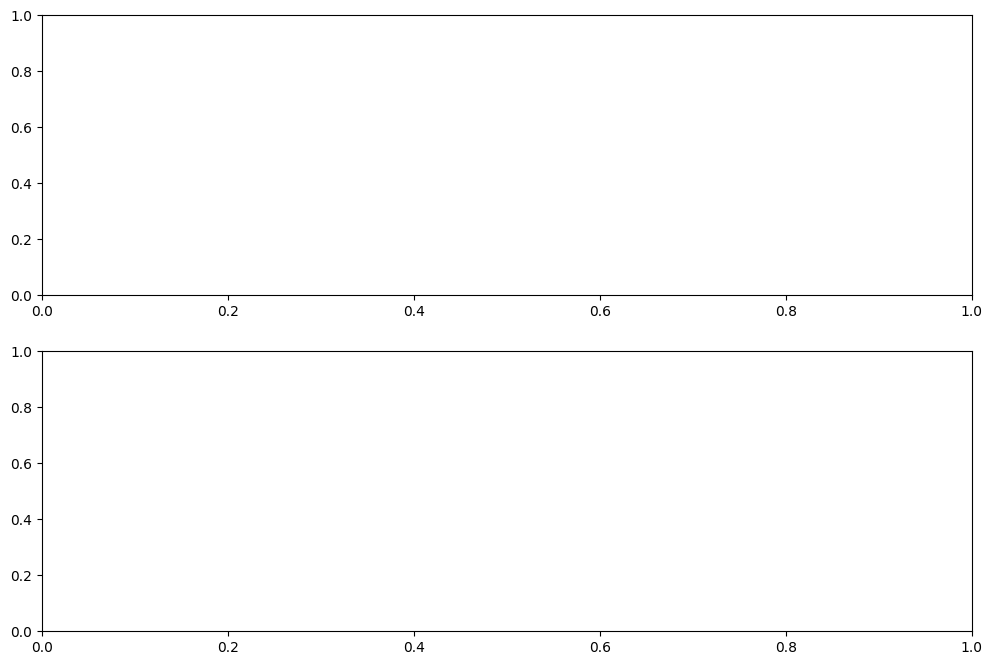

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [ ]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label:(get_spectrogram(audio),label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [ ]:
train_spectrogram_ds=make_spec_ds(train_ds)
val_spectrogram_ds=make_spec_ds(val_ds)
test_spectrogram_ds=make_spec_ds(test_ds)

In [ ]:
for example_spectrograms,example_spect_labels in train_spectrogram_ds.take(1):
    break

In [ ]:
row=3
cols=3
n=row*cols
fig,axes=plt.subplots(rows,cols,figsize=(20,19))
for i in range(n):
    r=i//cols
    c=i%cols
    ax=axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(),ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
plt.show()    

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

**Normalization**

In [ ]:
input_shape=example_spectrogram.shape[1:]
print("Input Shape",input_shape)
num_labels=len(label_names)

norm_layer=layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec,label:spec))


In [ ]:
model=models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(32,3,activation='relu'),
    layers.Conv2D(64,3,activation='relu'),
    layers.Conv2D(64,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
    
])

model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
Epochs=13
history=model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=Epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1,patience=2)
)

In [ ]:
metrics=history.history
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(history.epoch,metrics['loss'],metrics['val_loss'])
plt.legend(['loss','val_loss'])
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [crossEntropy]')
plt.subplot(1,2,2)
plt.plot(history.epoch,100*np.array(metrics['accuracy']),100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy','val_accuracy'])
plt.ylim([0,100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrogram_ds,return_dict=True)

In [ ]:
y_pred=model.predict(test_spectrogram_ds)

In [ ]:
y_pred=tf.argmax(y_pred,axis=1)

In [ ]:
y_true=tf.concat(list(test_spectrogram_ds.map(lambda s,lab:lab)),axis=0)

In [ ]:
confuse_matrix=tf.math.confusion_matrix(y_true,y_pred)
plt.figure(figsize=(20,15))
sns.heatmap(confuse_matrix,xticklabels=label_names,yticklabels=label_names,
           annot=True,fmt='g')
plt.xlabel('prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
x=data_dir/'go/0137b3f4_nohash_4.wav'
x=tf.io.read_file(str(x))
x,sample_rate=tf.audio.decode_wav(x,desired_channels=1,desired_samples=16000,)
x=tf.squeeze(x,axis=-1)
waveform=x
x=get_spectrogram(x)
x=x[tf.newaxis,...]
prediction=model(x)
x_labels=['no','yes','down','go','left','up','right','stop']
plt.bar(x_labels,tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()
display.display(display.Audio(waveform,rate=16000))

**Export the model with preprocessing**

In [ ]:
model.save('modelaudio.hdf5')